#### Compute pathway acts for the subnetwork created by looking for hubs (TDA mega cluster) and their targets

In [2]:
import pandas as pd
import numpy as np
import decoupler as dc
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from upsetplot import UpSet, from_contents
plt.rcParams['svg.fonttype'] = 'none'

/home/mmultari/miniconda3/envs/GRN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
GRN = pd.read_csv('../Data/Network_GRN_HIVE_curated.txt',sep='\t')
GRN.rename(columns={'tf.name':'source','target.name':'target'}, inplace=True)
Dataset = pd.read_csv('../DEA/Merge_stat_all.tsv',index_col=0, sep='\t')

In [4]:
Dataset = Dataset.reset_index()
Dataset['OLN'] = Dataset['index'].str.extract(r'(Solyc\d+g\d+)')
Dataset = Dataset.rename(columns={'index':'Gene_Name'})
Dataset.columns=Dataset.columns.str.replace('stat_','', regex=False)
Dataset = Dataset.fillna(0)

In [5]:
hubs_tda = pd.read_csv('./Results_hubs_by_TDA_mega_cluster.tsv',sep='\t')

In [6]:
GRN_hubs = GRN[GRN['source'].isin(hubs_tda['OLN'])]
## ok 

In [7]:
filtered_dataset = Dataset[Dataset['OLN'].isin(GRN_hubs['source']) | Dataset['OLN'].isin(GRN_hubs['target'])]
filtered_dataset = filtered_dataset.set_index('OLN')
filtered_dataset.index.name=None

In [16]:
# len(pd.concat([GRN_hubs['source'], GRN_hubs['target']]).unique()) == filtered_dataset.shape[0]

In [8]:
conditions = ['Pinfestans','Cfulvum','PSTVd_S23','PSTVd_M','Bcinerea','Mincognita_7dpi','Mincognita_14dpi']
matrix = filtered_dataset[conditions].T

In [9]:
sly_kegg = pd.read_csv('../Data/KEGG_background.txt',sep='\t')
sly_kegg = sly_kegg[['gene.name','pathway.name']].drop_duplicates()
sly_kegg.rename(columns={'pathway.name':'source','gene.name':'target'}, inplace=True)
sly_kegg_filt = sly_kegg[sly_kegg['target'].isin(matrix.columns)]

In [14]:
sly_kegg_filt

,target,source
0,Solyc10g050890,Metabolic pathways
51,Solyc05g007590,Metabolic pathways
57,Solyc06g053310,Metabolic pathways
59,Solyc10g079500,Metabolic pathways
64,Solyc12g099360,Metabolic pathways
...,...,...
1618,Solyc02g091100,Peroxisome
1639,Solyc04g081490,Motor proteins
1642,Solyc12g099540,Motor proteins
1643,Solyc03g120810,Motor proteins


In [10]:
pathway_acts, pathway_pvals = dc.run_mlm(mat=matrix, net=sly_kegg_filt, verbose=True, weight=None, min_n=5)

Running mlm on mat with 7 samples and 546 targets for 5 sources.


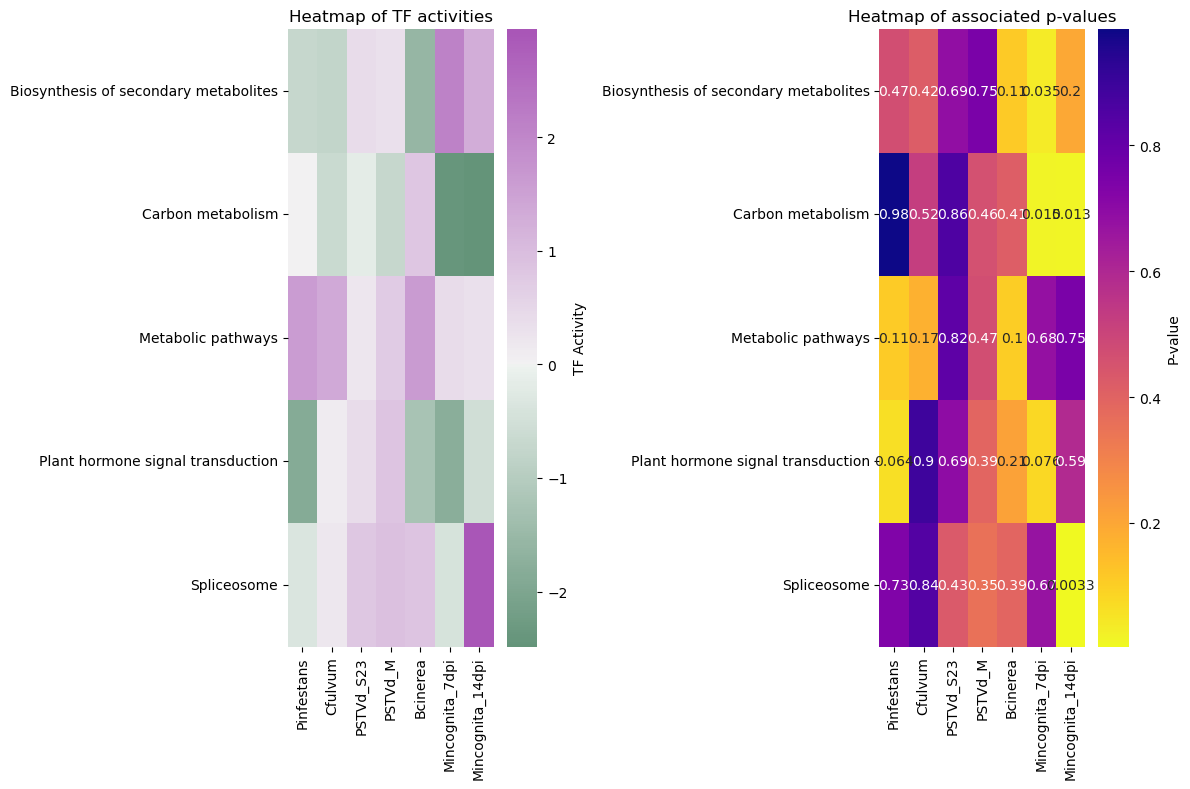

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,8), tight_layout=True)

axes[0].set_title('Heatmap of TF activities')
sns.heatmap(pathway_acts.T, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=False, cbar_kws={'label': 'TF Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(pathway_pvals.T, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})

plt.savefig('Plot/Heatmap_activity_hubs_GRN.svg', format='svg')
plt.show()

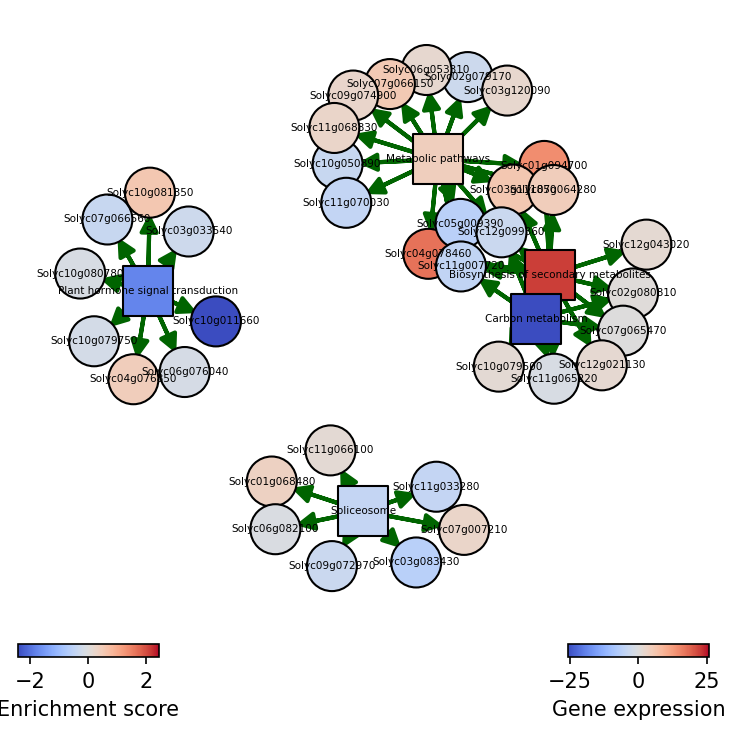

In [13]:
dc.plot_network(
    net=sly_kegg_filt,
    obs=matrix.iloc[[5], :],
    act=pathway_acts.iloc[[5], :],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True,
    s_cmap='coolwarm',
    t_cmap='coolwarm'
)

In [12]:
import igraph as ig
graph = ig.Graph.TupleList(GRN_hubs[['source', 'target']].itertuples(index=False), directed=True)

In [13]:
print("Summary of the graph:")
print("Number of vertices:", graph.vcount())
print("Number of edges:", graph.ecount())

Summary of the graph:
Number of vertices: 491
Number of edges: 972


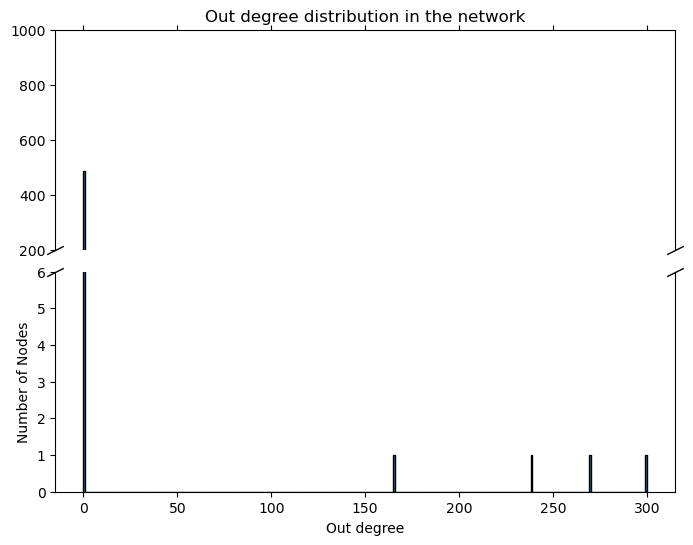

In [14]:
outdegree = graph.outdegree()
bins = range(min(outdegree), max(outdegree)+1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
fig.subplots_adjust(hspace=0.1)  # adjust space between Axes

# plot the same data on both Axes
ax1.hist(outdegree, bins=bins, edgecolor='black')
ax2.hist(outdegree, bins=bins, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(200, 1000)  # outliers only
ax2.set_ylim(0, 6)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel('Out degree')
ax2.set_ylabel('Number of Nodes')
ax1.set_title('Out degree distribution in the network')
plt.show()

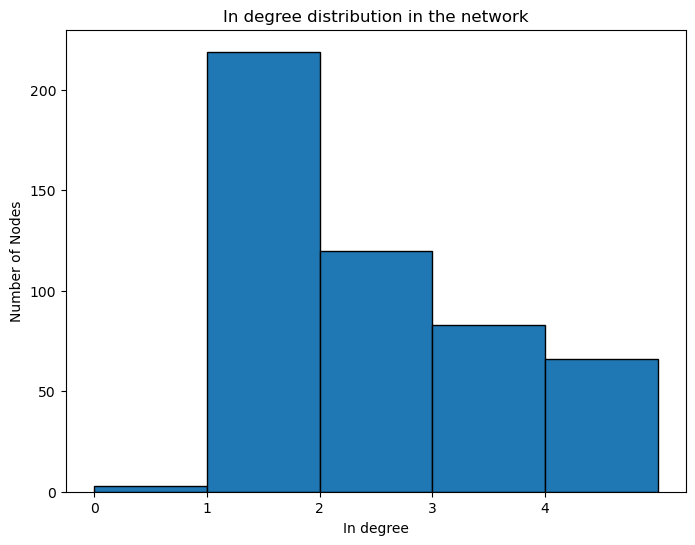

In [15]:
indegree = graph.indegree()
# Calculate bin edges
bins = range(min(graph.indegree()), max(graph.indegree()) + 2)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(indegree, bins=bins, edgecolor='black', align='mid')

# Set x-axis ticks to integers
plt.xticks(range(min(graph.indegree()), max(graph.indegree()) + 1))

# Add labels and title
plt.xlabel('In degree')
plt.ylabel('Number of Nodes')
plt.title('In degree distribution in the network')
# Show the plot
plt.show()

In [16]:
info = pd.read_csv('../Results/Information_Gene_Cluster_Pathway.tsv',sep='\t')

In [17]:
info_GRN_hubs=info[info['Gene'].isin(graph.vs['name'])]

In [19]:
info_GRN_hubs[info_GRN_hubs['Pathway'].str.contains(r'Plant hormone signal transduction')]

,Gene,MegaCluster,Cluster,Pathway
676,Solyc04g076850,"[1, 2]","[2, 3, 7]",['Plant hormone signal transduction']
1080,Solyc07g066560,"[0, 1, 2]","[2, 7, 8]",['Plant hormone signal transduction']
1338,Solyc10g011660,"[2, 3]","[7, 9, 18, 19]",['Plant hormone signal transduction']
1380,Solyc10g079750,"[1, 2, 3]","[2, 7, 9, 13, 15, 18, 19]",['Plant hormone signal transduction']
1396,Solyc10g080780,"[2, 3]","[7, 9, 18, 19]",['Plant hormone signal transduction']
1400,Solyc10g081350,[1],"[2, 3, 5]",['Plant hormone signal transduction']


In [20]:
info_GRN_hubs[info_GRN_hubs['Pathway'].str.contains(r'Carbon metabolism')]

,Gene,MegaCluster,Cluster,Pathway
290,Solyc02g080810,[1],[2],"['Biosynthesis of secondary metabolites', 'Car..."
1068,Solyc07g065470,"[0, 1, 2, 4]","[2, 3, 5, 7, 11, 16]","['Biosynthesis of amino acids', 'Biosynthesis ..."
1450,Solyc11g007720,"[1, 2]","[3, 5, 7]","['2-Oxocarboxylic acid metabolism', 'Biosynthe..."
1516,Solyc11g065220,"[0, 1, 2, 3, 4]","[0, 2, 3, 5, 7, 11, 13, 14, 16]",['Amino sugar and nucleotide sugar metabolism'...
1681,Solyc12g099360,"[0, 1, 2, 3, 4]","[3, 5, 7, 9, 11, 16, 18, 19]","['Biosynthesis of secondary metabolites', 'But..."


In [21]:
info_GRN_hubs[info_GRN_hubs['Pathway'].str.contains(r'Biosynthesis of secondary metabolites')]['Gene'].to_csv('./ID_Secondary_Metabolites.txt',index=False,header=False)

------------

In [45]:
Pathway_size = pd.read_csv('../Results/Results_pathway_size.txt', sep='\t')

In [46]:
import igraph as ig
graph = ig.Graph.TupleList(sly_kegg_filt[['source', 'target']].itertuples(index=False), directed=True)

In [47]:
# Get outdegree for each node
outdegree = graph.outdegree()

# Create a DataFrame with vertex names and outdegree
outdegree_df = pd.DataFrame({
    "Pathway": graph.vs["name"],  # Assuming vertices have a 'name' attribute
    "Number_GRN_Hubs": outdegree,
})
# Remove rows where outdegree is 0
outdegree_df = outdegree_df[outdegree_df["Number_GRN_Hubs"] > 0]

outdegree_df = outdegree_df.sort_values(by='Number_GRN_Hubs', ascending=False)

In [48]:
Pathway_size = pd.merge(Pathway_size, outdegree_df, on='Pathway', how='inner')

In [50]:
Pathway_size['Ratio_Hubs'] = Pathway_size['Number_GRN_Hubs']/Pathway_size['Number_GRN']

In [52]:
Pathway_size.to_csv('./Results_pathway_size_GRN_Hubs.txt',sep='\t',index=False)